## Fitting Induction data to the Community model using softmax rule

In [1]:
import os
import numpy as np
from scipy import optimize
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from tesser import cython_fit
from tesser import util
from tesser import network
from scipy.spatial import distance
import importlib

## Load data for all subjects

In [2]:
data_dir= "/mnt/c/Users/rodv2/Dropbox/tesser_successor/Data"
tdir = "/home/work-machine/Preston_Lab/tesser_successor/Data"
struct_all = util.load_struct(data_dir)
induct_all = util.load_induct(data_dir)
n_states =21

# get community matrix


In [3]:
net = network.temp_node_info()
comm = 1 - distance.squareform(distance.pdist(net['comm'][:, None], 'hamming'))

<ipython-input-3-d132e81e18b8>:2: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  comm = 1 - distance.squareform(distance.pdist(net['comm'][:, None], 'hamming'))


## Fit each individual subject

In [4]:
# Using a hybrid model function when weight 'w' is set to 0 the model is fixed only to the community matrix.
fixed = {'w': 0}
var_names = ['gamma', 'alpha', 'tau']
var_bounds = {'gamma': [0, 1], 'alpha': [0, 1], 'tau': [0, 10]}
results = cython_fit.fit_induct_indiv(struct_all, induct_all, fixed, var_names, var_bounds, split =False,
                               n_states=n_states, verbose=False, model_type='comm', model=comm, split_list =[])

Estimating parameters for 100...
Estimating parameters for 101...
Estimating parameters for 102...
Estimating parameters for 103...
Estimating parameters for 104...
Estimating parameters for 105...
Estimating parameters for 106...
Estimating parameters for 107...
Estimating parameters for 108...
Estimating parameters for 109...
Estimating parameters for 110...
Estimating parameters for 111...
Estimating parameters for 112...
Estimating parameters for 113...
Estimating parameters for 114...
Estimating parameters for 115...
Estimating parameters for 116...
Estimating parameters for 117...
Estimating parameters for 119...
Estimating parameters for 120...
Estimating parameters for 121...
Estimating parameters for 122...
Estimating parameters for 123...
Estimating parameters for 124...
Estimating parameters for 125...
Estimating parameters for 126...
Estimating parameters for 127...
Estimating parameters for 128...
Estimating parameters for 129...
Estimating parameters for 130...
Estimating

In [5]:
results = results.set_index('subject')
results.head()

,w,gamma,alpha,tau,log_like
subject,,,,,
100,0,0.228560,0.237937,10.000000,-29.564660
101,0,0.434477,0.847508,5.249287,-28.921418
102,0,0.233954,0.719024,0.621335,-18.923571
103,0,0.504124,0.998884,2.592969,-28.345601
104,0,0.246703,0.864702,10.000000,-29.164660
105,0,0.756573,0.352705,0.965165,-24.151673
106,0,0.465843,0.667376,1.091356,-25.127323
107,0,0.554117,0.422805,3.476075,-28.682140
108,0,0.920215,0.538343,5.222175,-28.921417


## Get response probabilities for the fitted models

In [6]:
importlib.reload(cython_fit)

<module 'tesser.cython_fit' from '/home/work-machine/Preston_Lab/tesser_successor/tesser/cython_fit.py'>

In [7]:
res_list = []
for subject in results.index.unique():
    subj_filter = f'SubjNum == {subject}'
    subj_struct = struct_all.query(subj_filter)
    subj_induct = induct_all.query(subj_filter)
    subj_param = results.loc[subject]
    param = {'alpha': subj_param['alpha'], 'gamma': subj_param['gamma'],
             'tau': subj_param['tau'], 'w' : subj_param['w']}
    res = cython_fit.assess_induct_fit_subject_hybrid(subj_struct, subj_induct, param, n_states, False, model=comm)
    res_list.append(res)
fitted = pd.concat(res_list, axis=0)

In [8]:
fitted

,SubjNum,TrialNum,QuestType,Environment,Source,Accuracy
0,100,1,Prim,ocean,Data,0.0
1,100,2,Bound2,desert,Data,0.0
2,100,3,Prim,desert,Data,1.0
3,100,4,Prim,ocean,Data,1.0
4,100,5,Prim,ocean,Data,0.0
...,...,...,...,...,...,...
79,138,38,Prim,desert,Model,0.5
80,138,39,Prim,forest,Model,0.5
81,138,40,Prim,ocean,Model,0.5
82,138,41,Bound1,forest,Model,0.5


## Plot individual differences in induction

In [9]:
# m = fitted.groupby(['Source', 'SubjNum', 'Environment'])['Accuracy'].mean().unstack(level=0)
# g = sns.scatterplot(x='Model', y='Data', hue='Environment', data=m.reset_index());
# g.set_xlim(0, 1.02);
# g.set_ylim(0, 1.02);
# g.set_aspect(1);
# g.plot((0, 1), (0, 1), '-k');

In [10]:
# m = fitted.groupby(['Source', 'SubjNum', 'QuestType'])['Accuracy'].mean().unstack(level=0)
# g = sns.scatterplot(x='Model', y='Data', hue='QuestType', data=m.reset_index());
# g.set_xlim(0, 1.02);
# g.set_ylim(0, 1.02);
# g.set_aspect(1);
# g.plot((0, 1), (0, 1), '-k');

## Plot group means

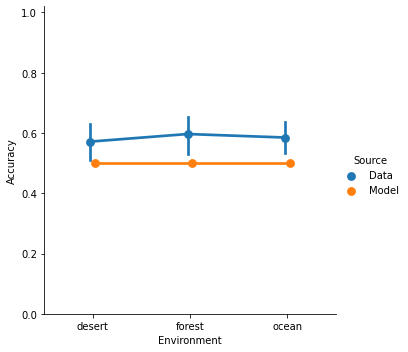

In [11]:
m = fitted.groupby(['Source', 'SubjNum', 'Environment'])['Accuracy'].mean()
g = sns.catplot(kind='point', x='Environment', y='Accuracy', 
                hue='Source', dodge=True, data=m.reset_index())
g.set(ylim=(0, 1.02));

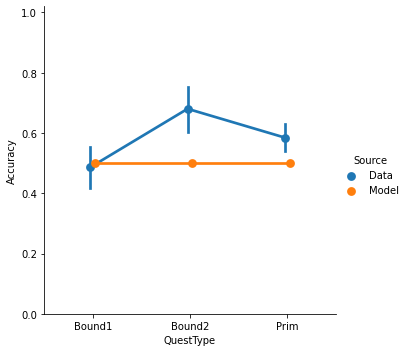

In [12]:
m = fitted.groupby(['Source', 'SubjNum', 'QuestType'])['Accuracy'].mean()
g = sns.catplot(kind='point', x='QuestType', y='Accuracy', 
                hue='Source', dodge=True, data=m.reset_index())
g.set(ylim=(0, 1.02));

In [16]:
results.to_csv("./Data/results/community_only.csv")